# Web Extension for Online Sentiment Detection
## Andrew Burton, Kyle West, Aneel Parmar
### Computer Science 571 - Winter 2024
#### Design and implementation of Database Systems
Welcome to our project notebook! In this space, we present a comprehensive overview of our web extension tailored for online sentiment detection. Developed as part of our coursework for Computer Science 571 during the Winter 2024 term, this project encapsulates the intricate design and training of our sentiment detection model.

This notebook primarily focuses on the fine-tuning and model training of various BERT (Bidirectional Encoder Representations from Transformers) models on the GoEmotions dataset. Our objective? Multilabel sequence classification—a task crucial for discerning nuanced sentiments within online content. Here, we delve into the intricacies of our methodology, shedding light on the process behind training these models to accurately classify sentiment across a spectrum of emotions. Join us as we explore the fascinating realm of sentiment analysis in the digital age.








# Setup
Before delving into the intricacies of our sentiment detection model, it's crucial to set up the necessary environment and prepare our data for training and evaluation. Follow the steps below to seamlessly replicate our setup:

## 1. Install Required Packages
Ensure you have the required Python packages installed. You can do this easily using `pip`:

In [1]:
!pip install -U accelerate
!pip install -U transformers
!pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 3.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import random
import numpy as np
import torch


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## 2. Define Constants
Define any necessary constants such as file paths, model configurations, and hyperparameters. These constants will streamline your workflow and ensure consistency throughout the project.

In [3]:
CHECKPOINTS = [
    'bert-base-cased',
    'albert-base-v2',
    'distilbert-base-cased',
    'roberta-base'
]
SEED = 42
SAMPLE_LENGTH = 50
THRESHOLD = 0.5
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01
DATASET = 'go_emotions'

set_seed(SEED)

## 3. Load the Dataset
Load the dataset into your environment. This could involve reading data from files, connecting to a database, or downloading from an online repository. Ensure that the dataset is properly formatted and compatible with your chosen machine learning framework.

In [4]:
import pandas as pd
from datasets import load_dataset
from sklearn.preprocessing import MultiLabelBinarizer

dataset = load_dataset('go_emotions')
labels = dataset['train'].features['labels'].feature.names

train = pd.DataFrame(dataset['train'], columns=['text', 'labels'])
test = pd.DataFrame(dataset['test'], columns=['text', 'labels'])
valid = pd.DataFrame(dataset['validation'], columns=['text', 'labels'])

mlb = MultiLabelBinarizer()

train_labels = mlb.fit_transform(train['labels']).astype(float)
train_labels = pd.DataFrame(train_labels, columns=mlb.classes_)

train_labels.style.set_caption('Train Labels')
display(train_labels)
display(train['text'].to_list()[:5])

test_labels = mlb.fit_transform(test['labels']).astype(float)
test_labels = pd.DataFrame(test_labels, columns=mlb.classes_)

test_labels.style.set_caption('Test Labels')
display(test_labels)
display(test['text'].to_list()[:20])

valid_labels = mlb.fit_transform(valid['labels']).astype(float)
valid_labels = pd.DataFrame(valid_labels, columns=mlb.classes_)

valid_labels.style.set_caption('Validation Labels')
display(valid_labels)
display(valid['text'].to_list()[:5])

train = pd.concat([train, train_labels], axis=1)
test = pd.concat([test, test_labels], axis=1)
valid = pd.concat([valid, valid_labels], axis=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43406,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43407,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


["My favourite food is anything I didn't have to cook myself.",
 'Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead',
 'WHY THE FUCK IS BAYLESS ISOING',
 'To make her feel threatened',
 'Dirty Southern Wankers']

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5423,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5425,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


['I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!',
 "It's wonderful because it's awful. At not with.",
 'Kings fan here, good luck to you guys! Will be an interesting game to watch! ',
 "I didn't know that, thank you for teaching me something today!",
 'They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.',
 'Thank you for asking questions and recognizing that there may be things that you don’t know or understand about police tactics. Seriously. Thank you.',
 'You’re welcome',
 '100%! Congrats on your job too!',
 'I’m sorry to hear that friend :(. It’s for the best most likely if she didn’t accept you for who you are',
 'Girlfriend weak as well, that jump was pathetic.',
 "[NAME] has towed the line of the Dark Side. He wouldn't cross it by doing something like this.",
 'Lol! But I love your last name though. XD',
 'Translation }}} I wish I could afford it.',
 "It's great that you're a re

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5424,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


['Is this in New Orleans?? I really feel like this is New Orleans.',
 'You know the answer man, you are programmed to capture those codes they send you, don’t avoid them!',
 "I've never been this sad in my life!",
 'The economy is heavily controlled and subsidized by the government. In any case, I was poking at the lack of nuance in US politics today',
 'He could have easily taken a real camera from a legitimate source and change the price in Word/Photoshop and then print it out.']

## 4. Explore the Data
It is helpful to explore any class imbalance in our data set before we go too far, since any significant class imbalance may not yield very performant reulsts for certain test classes.

### Show Data Samples

In [5]:
display(train.head())
display(test.head())
display(valid.head())

,text,labels,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to...,[27],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,"Now if he does off himself, everyone will thin...",[27],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,WHY THE FUCK IS BAYLESS ISOING,[2],0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,To make her feel threatened,[14],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Dirty Southern Wankers,[3],0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,text,labels,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
0,I’m really sorry about your situation :( Altho...,[25],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,It's wonderful because it's awful. At not with.,[0],1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Kings fan here, good luck to you guys! Will be...",[13],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"I didn't know that, thank you for teaching me ...",[15],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,They got bored from haunting earth for thousan...,[27],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,text,labels,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
0,Is this in New Orleans?? I really feel like th...,[27],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,"You know the answer man, you are programmed to...","[4, 27]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,I've never been this sad in my life!,[25],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,The economy is heavily controlled and subsidiz...,"[4, 27]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,He could have easily taken a real camera from ...,[20],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Show Class Distribution

<Axes: ylabel='Frequency'>

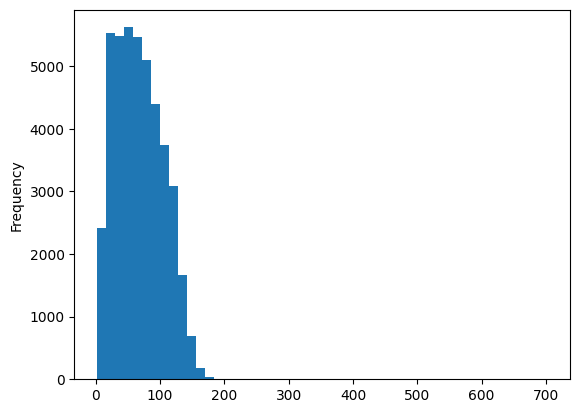

In [6]:
text_lengths = train['text'].str.len()
text_lengths.plot.hist(bins=50)

In [7]:
class_counts = [ c for cls in train['labels'] for c in cls]
class_counts_series = pd.Series(class_counts).value_counts(sort=False)
sorted_cls_df = class_counts_series.sort_index()
display(pd.DataFrame(sorted_cls_df))

,count
0,4130
1,2328
2,1567
3,2470
4,2939
5,1087
6,1368
7,2191
8,641
9,1269


<Axes: ylabel='Frequency'>

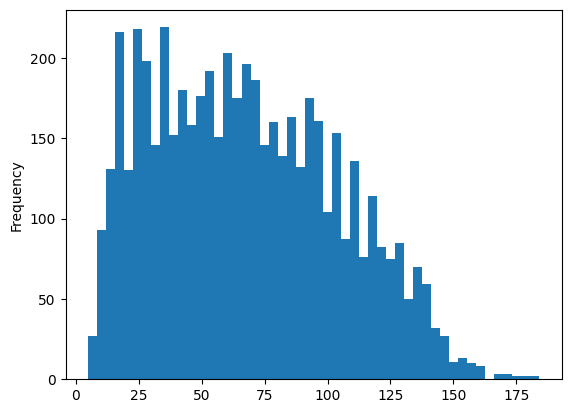

In [8]:
text_lengths = test['text'].str.len()
text_lengths.plot.hist(bins=50)

In [9]:
class_counts = [ c for cls in test['labels'] for c in cls]
class_counts_series = pd.Series(class_counts).value_counts()
sorted_cls_df = pd.DataFrame(class_counts_series).sort_index()
display(sorted_cls_df)

,count
0,504
1,264
2,198
3,320
4,351
5,135
6,153
7,284
8,83
9,151


<Axes: ylabel='Frequency'>

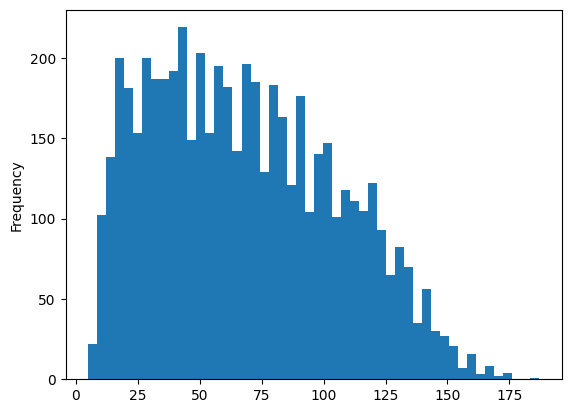

In [10]:
text_lengths = valid['text'].str.len()
text_lengths.plot.hist(bins=50)

In [11]:
class_counts = [ c for cls in valid['labels'] for c in cls]
class_counts_series = pd.Series(class_counts).value_counts()
sorted_cls_df = pd.DataFrame(class_counts_series).sort_index()
display(sorted_cls_df)

,count
0,488
1,303
2,195
3,303
4,397
5,153
6,152
7,248
8,77
9,163


## 5. Define A Label Mapping
Map the labels from the dataset into a `label2id` and `id2label` map that can be used by our model to classify our samples.

In [12]:
id2label = {k: v for k, v in enumerate(labels)}
id2label_df = pd.DataFrame(id2label.items(), columns=['id', 'label'])
display(id2label_df)

,id,label
0,0,admiration
1,1,amusement
2,2,anger
3,3,annoyance
4,4,approval
5,5,caring
6,6,confusion
7,7,curiosity
8,8,desire
9,9,disappointment


In [13]:
label2id = {v: k for k, v in id2label.items()}
label2id_df = pd.DataFrame(label2id.items(), columns=['label', 'id'])
display(label2id_df)

,label,id
0,admiration,0
1,amusement,1
2,anger,2
3,annoyance,3
4,approval,4
5,caring,5
6,confusion,6
7,curiosity,7
8,desire,8
9,disappointment,9


## 6. Define A Custom Dataset Class
If the dataset requires custom preprocessing or handling, define a custom dataset class. This class should inherit from the appropriate dataset class provided by your machine learning framework (e.g., PyTorch's `Dataset` class).

In [14]:
import torch
from torch.utils.data import Dataset

class GoEmotionDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=256):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

    ids = encoding['input_ids'].flatten()
    mask = encoding['attention_mask'].flatten()

    return {
        'input_ids': ids,
        'attention_mask': mask,
        'labels': label.clone().detach()
    }

# Stage 2

## 1. Tokenize the Data Splits
To prepare our text data for modeling, we employ a tokenizer to convert raw text into numerical representations suitable for input into our neural network model. We utilize the tokenizer provided by the Transformers library, tailored specifically for the BERT model architecture. This tokenizer efficiently handles tokenization, padding, and special token insertion, ensuring seamless integration with our sentiment detection pipeline.


In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(CHECKPOINTS[2])

train_dataset = GoEmotionDataset(train['text'].tolist(), train_labels.values, tokenizer, SAMPLE_LENGTH)
test_dataset = GoEmotionDataset(test['text'].tolist(), test_labels.values, tokenizer, SAMPLE_LENGTH)
valid_dataset = GoEmotionDataset(valid['text'].tolist(), valid_labels.values, tokenizer, SAMPLE_LENGTH)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [16]:
def get_token_lengths(texts):
    token_lengths = []
    for text in texts:
        tokens = tokenizer.tokenize(text)
        token_lengths.append(len(tokens))

    return token_lengths

train_token_lengths = get_token_lengths(train['text'].tolist())
test_token_lengths = get_token_lengths(test['text'].tolist())
valid_token_lengths = get_token_lengths(valid['text'].tolist())

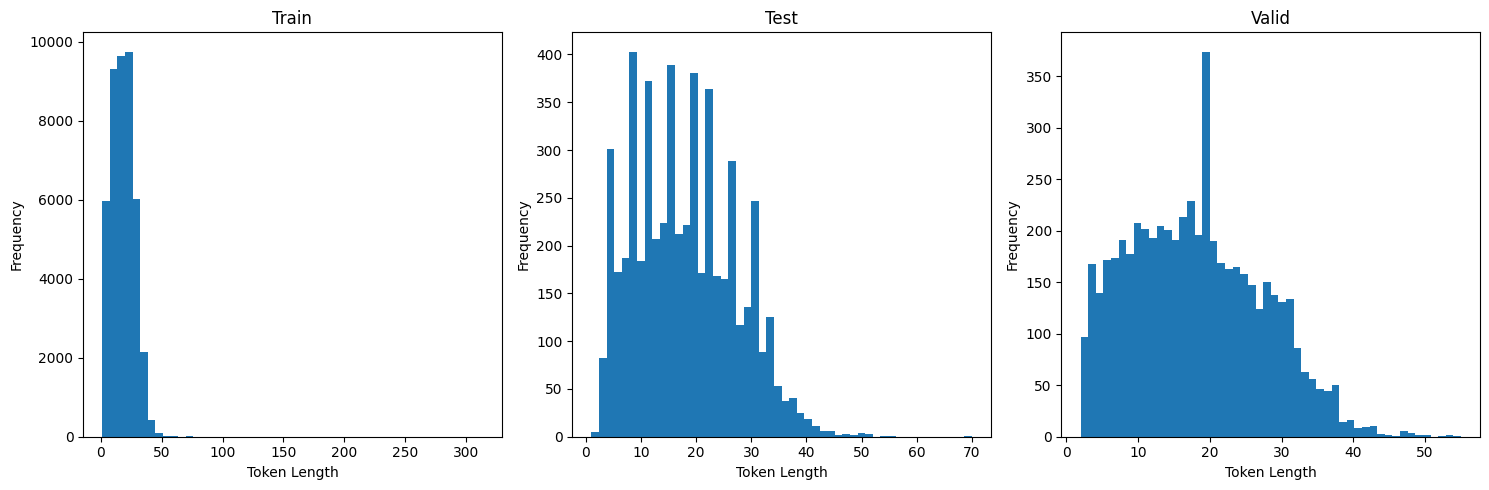

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_token_lengths, bins=50)
plt.title('Train')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(test_token_lengths, bins=50)
plt.title('Test')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(valid_token_lengths, bins=50)
plt.title('Valid')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

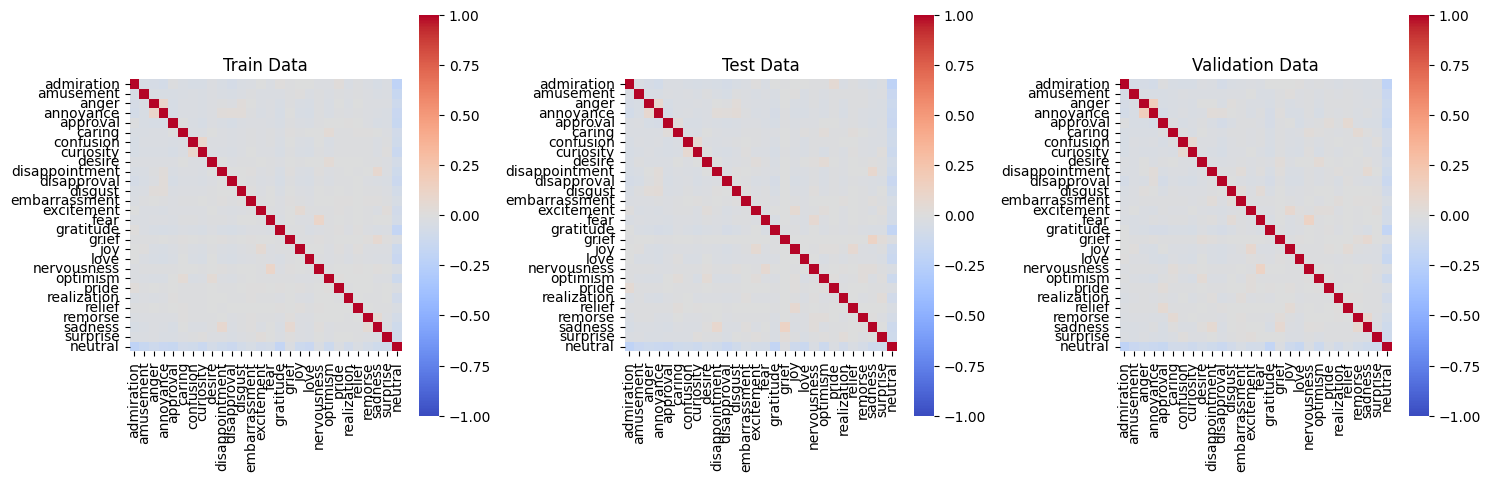

In [18]:
import seaborn as sns

train_label_df = train.iloc[:,2:]
test_label_df = test.iloc[:,2:]
valid_label_df = valid.iloc[:,2:]

train_corr = train_label_df.corr()
test_corr = test_label_df.corr()
valid_corr = valid_label_df.corr()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot train correlation
sns.heatmap(
    train_corr,
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True,
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[0]  # assign plot to first subplot
)
axes[0].set_title('Train Data')

# Plot test correlation
sns.heatmap(
    test_corr,
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True,
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[1]  # assign plot to second subplot
)
axes[1].set_title('Test Data')

# Plot valid correlation
sns.heatmap(
    valid_corr,
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True,
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[2]  # assign plot to third subplot
)
axes[2].set_title('Validation Data')

plt.tight_layout()
plt.show()

## 2. Define the Model
Our sentiment detection model is based on the BERT (Bidirectional Encoder Representations from Transformers) architecture—a powerful transformer-based model renowned for its effectiveness in natural language understanding tasks. Leveraging the Hugging Face Transformers library, we instantiate a BERT model fine-tuned for multilabel sequence classification. This model architecture comprises multiple transformer layers, enabling it to capture intricate semantic relationships within textual data, thereby facilitating accurate sentiment classification across a diverse range of emotions.


## 3. Establish Label Metrics For Performance Evaluation
In multilabel sequence classification, traditional evaluation metrics may not suffice. Therefore, we utilize specialized label-based metrics to assess the performance of our sentiment detection model. These metrics include precision, recall, F1-score, and Hamming loss, providing insights into the model's ability to correctly identify individual sentiment labels across the dataset.


In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from transformers import EvalPrediction
import torch

def multi_label_metrics(predictions, labels, threshold=0.5):
    sigmoid = torch.nn.Sigmoid()
    preds = sigmoid(torch.tensor(predictions))

    y_pred = np.zeros(preds.shape)
    y_pred[np.where(preds >= threshold)] = 1

    y_true = labels
    f1_micro = f1_score(y_true, y_pred, average='micro')
    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)

    metrics = {
        'f1_micro': f1_micro,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_macro': f1_macro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_weighted': f1_weighted,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'accuracy': accuracy
    }

    # Get per label report
    label_df = {}
    for label_idx, label_name in id2label.items():
        label_metrics = calc_label_metrics(label_name, y_true[:, label_idx], y_pred[:, label_idx], threshold)
        label_df[label_name] = label_metrics
    df = pd.DataFrame(label_df).T
    df.style.set_caption('Metrics By Class')
    display(pd.DataFrame(label_df).T)

    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(preds, p.label_ids)
    return result

def calc_label_metrics(label, y_targets, y_preds, threshold=THRESHOLD):
    return {
        'label': label,
        'accuracy': accuracy_score(y_targets, y_preds),
        'precision': precision_score(y_targets, y_preds, average='macro', zero_division=0),
        'recall': recall_score(y_targets, y_preds, average='macro', zero_division=0),
        'f1': f1_score(y_targets, y_preds, average='macro', zero_division=0),
        'support': y_targets.sum(),
        'threshold': threshold,
    }

## 4. Trainer Augmentation
During the training process, per epoch evaluation metrics are not particularly meaningful due to the multilabel nature of this classification task. To address this we will augment the Trainer construct provided by the transformers library in order to assess the performance of individual classes and their improvement at each step of the training.

In [25]:
from transformers import Trainer

class MultiLabelTrainer(Trainer):
    def log_metrics(self, metrics, epoch):
        super().log_metrics(metrics, epoch)

## 5. Configure the Trainer
With our dataset prepared and model architecture defined, we embark on the training phase to fine-tune our sentiment detection model. Leveraging the powerful capabilities of modern deep learning frameworks such as PyTorch, we iteratively optimize the model parameters using techniques like stochastic gradient descent (SGD) or Adam optimization. Throughout the training process, we monitor key metrics and adjust hyperparameters as necessary to ensure optimal model performance.


In [26]:
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification

for checkpoint in CHECKPOINTS:
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)

  train_dataset = GoEmotionDataset(train['text'].tolist(), train_labels.values, tokenizer, SAMPLE_LENGTH)
  test_dataset = GoEmotionDataset(test['text'].tolist(), test_labels.values, tokenizer, SAMPLE_LENGTH)
  valid_dataset = GoEmotionDataset(valid['text'].tolist(), valid_labels.values, tokenizer, SAMPLE_LENGTH)

  model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels), problem_type='multi_label_classification', id2label=id2label, label2id=label2id)

  args = TrainingArguments(
      f'{checkpoint}-go-emotion',
      evaluation_strategy = 'epoch',
      save_strategy = 'epoch',
      learning_rate=LEARNING_RATE,
      per_device_train_batch_size=TRAIN_BATCH_SIZE,
      per_device_eval_batch_size=EVAL_BATCH_SIZE,
      num_train_epochs=NUM_EPOCHS,
      weight_decay=WEIGHT_DECAY,
      load_best_model_at_end=True,
      metric_for_best_model='f1_weighted',
  )

  trainer = MultiLabelTrainer(
      model,
      args,
      train_dataset=train_dataset,
      eval_dataset=test_dataset,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics
  )

  trainer.train()
  trainer.evaluate(valid_dataset)
  trainer.save_model(f'{checkpoint}-go-emotion')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Micro,Precision Micro,Recall Micro,F1 Macro,Precision Macro,Recall Macro,F1 Weighted,Precision Weighted,Recall Weighted,Accuracy
1,0.094600,0.089876,0.541063,0.696344,0.442408,0.364770,0.543219,0.325112,0.495415,0.673736,0.442408,0.410356
2,0.079900,0.083815,0.576312,0.704821,0.487439,0.428143,0.596808,0.366013,0.548317,0.682228,0.487439,0.459554


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.937903,0.815147,0.81795,0.81654,504.0,0.5
amusement,amusement,0.979547,0.872725,0.924555,0.896721,264.0,0.5
anger,anger,0.961305,0.720734,0.688364,0.703103,198.0,0.5
annoyance,annoyance,0.94122,0.770767,0.504492,0.494082,320.0,0.5
approval,approval,0.94251,0.830344,0.590032,0.632076,351.0,0.5
caring,caring,0.977704,0.848995,0.584335,0.632063,135.0,0.5
confusion,confusion,0.972729,0.752442,0.681345,0.710571,153.0,0.5
curiosity,curiosity,0.949696,0.746177,0.710651,0.726785,284.0,0.5
desire,desire,0.987286,0.869258,0.625851,0.685978,83.0,0.5
disappointment,disappointment,0.97236,0.986178,0.503311,0.499571,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.944352,0.841986,0.816162,0.828414,504.0,0.5
amusement,amusement,0.983048,0.901914,0.919207,0.910355,264.0,0.5
anger,anger,0.968859,0.812078,0.65584,0.705557,198.0,0.5
annoyance,annoyance,0.940114,0.712729,0.57274,0.602066,320.0,0.5
approval,approval,0.942325,0.790547,0.625735,0.67,351.0,0.5
caring,caring,0.978625,0.845987,0.61729,0.672344,135.0,0.5
confusion,confusion,0.973835,0.78041,0.624796,0.670596,153.0,0.5
curiosity,curiosity,0.950249,0.749675,0.702626,0.723275,284.0,0.5
desire,desire,0.987102,0.811492,0.685063,0.731584,83.0,0.5
disappointment,disappointment,0.973282,0.781972,0.564898,0.601313,151.0,0.5


Epoch,Training Loss,Validation Loss,F1 Micro,Precision Micro,Recall Micro,F1 Macro,Precision Macro,Recall Macro,F1 Weighted,Precision Weighted,Recall Weighted,Accuracy
1,0.094600,0.089876,0.541063,0.696344,0.442408,0.364770,0.543219,0.325112,0.495415,0.673736,0.442408,0.410356
2,0.079900,0.083815,0.576312,0.704821,0.487439,0.428143,0.596808,0.366013,0.548317,0.682228,0.487439,0.459554
3,0.064000,0.086267,0.576085,0.669667,0.505451,0.445502,0.556171,0.394377,0.558623,0.650368,0.505451,0.464529
4,0.049400,0.094786,0.572781,0.629160,0.525675,0.466923,0.539160,0.430935,0.559360,0.610936,0.525675,0.466003
5,0.035600,0.101587,0.574561,0.610745,0.542424,0.474459,0.536102,0.440030,0.565140,0.596459,0.542424,0.468583


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.945089,0.849786,0.806773,0.82646,504.0,0.5
amusement,amusement,0.981021,0.875954,0.941504,0.905734,264.0,0.5
anger,anger,0.96757,0.803416,0.628445,0.677392,198.0,0.5
annoyance,annoyance,0.936613,0.69171,0.60603,0.633807,320.0,0.5
approval,approval,0.937535,0.740796,0.669584,0.697646,351.0,0.5
caring,caring,0.972729,0.713833,0.682842,0.697022,135.0,0.5
confusion,confusion,0.974019,0.770398,0.682008,0.716878,153.0,0.5
curiosity,curiosity,0.953013,0.769376,0.697431,0.726963,284.0,0.5
desire,desire,0.986549,0.81388,0.637338,0.689877,83.0,0.5
disappointment,disappointment,0.97236,0.744254,0.564425,0.59823,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.93864,0.814272,0.832604,0.82309,504.0,0.5
amusement,amusement,0.981758,0.885673,0.931108,0.906956,264.0,0.5
anger,anger,0.96628,0.767178,0.676368,0.711492,198.0,0.5
annoyance,annoyance,0.933296,0.669189,0.599874,0.623385,320.0,0.5
approval,approval,0.92869,0.691541,0.642314,0.662336,351.0,0.5
caring,caring,0.975493,0.747116,0.702305,0.722303,135.0,0.5
confusion,confusion,0.973466,0.763077,0.675378,0.709743,153.0,0.5
curiosity,curiosity,0.946195,0.730418,0.748724,0.739151,284.0,0.5
desire,desire,0.985996,0.775953,0.690432,0.725025,83.0,0.5
disappointment,disappointment,0.970518,0.701467,0.582776,0.615124,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.939561,0.817171,0.834003,0.825296,504.0,0.5
amusement,amusement,0.979915,0.878357,0.91756,0.896862,264.0,0.5
anger,anger,0.963884,0.741917,0.692132,0.713831,198.0,0.5
annoyance,annoyance,0.927953,0.655069,0.620469,0.634981,320.0,0.5
approval,approval,0.923715,0.675045,0.651588,0.662225,351.0,0.5
caring,caring,0.97494,0.740091,0.694803,0.714902,135.0,0.5
confusion,confusion,0.970149,0.724139,0.69271,0.707126,153.0,0.5
curiosity,curiosity,0.948775,0.741252,0.725135,0.732863,284.0,0.5
desire,desire,0.986733,0.801195,0.678945,0.723915,83.0,0.5
disappointment,disappointment,0.967385,0.668289,0.60368,0.627462,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.947659,0.838827,0.843823,0.841301,488.0,0.5
amusement,amusement,0.975488,0.874277,0.903181,0.888106,303.0,0.5
anger,anger,0.966642,0.761442,0.718568,0.737875,195.0,0.5
annoyance,annoyance,0.931994,0.6666,0.644157,0.65436,303.0,0.5
approval,approval,0.91854,0.691956,0.664889,0.677068,397.0,0.5
caring,caring,0.970881,0.730181,0.677222,0.699942,153.0,0.5
confusion,confusion,0.969591,0.71164,0.658501,0.680887,152.0,0.5
curiosity,curiosity,0.952635,0.730349,0.750594,0.739973,248.0,0.5
desire,desire,0.986178,0.753113,0.743388,0.748151,77.0,0.5
disappointment,disappointment,0.965536,0.671152,0.595812,0.621613,163.0,0.5


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Micro,Precision Micro,Recall Micro,F1 Macro,Precision Macro,Recall Macro,F1 Weighted,Precision Weighted,Recall Weighted,Accuracy
1,0.150400,0.148114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.141300,0.129885,0.363049,0.569787,0.266393,0.054643,0.053144,0.058138,0.226810,0.201436,0.266393,0.272711
3,0.113800,0.113318,0.444799,0.681789,0.330068,0.159397,0.181356,0.146797,0.346713,0.379534,0.330068,0.325963
4,0.109600,0.108696,0.435590,0.687926,0.318692,0.163004,0.176231,0.153016,0.343790,0.375507,0.318692,0.310853
5,0.103100,0.105968,0.444976,0.712100,0.323590,0.202536,0.248928,0.186288,0.359752,0.421702,0.323590,0.316934


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.907131,0.453566,0.5,0.475652,504.0,0.5
amusement,amusement,0.951354,0.475677,0.5,0.487535,264.0,0.5
anger,anger,0.963516,0.481758,0.5,0.490709,198.0,0.5
annoyance,annoyance,0.941036,0.470518,0.5,0.484811,320.0,0.5
approval,approval,0.935323,0.467662,0.5,0.48329,351.0,0.5
caring,caring,0.975124,0.487562,0.5,0.493703,135.0,0.5
confusion,confusion,0.971808,0.485904,0.5,0.492851,153.0,0.5
curiosity,curiosity,0.947669,0.473835,0.5,0.486566,284.0,0.5
desire,desire,0.984706,0.492353,0.5,0.496147,83.0,0.5
disappointment,disappointment,0.972176,0.486088,0.5,0.492946,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.907131,0.453566,0.5,0.475652,504.0,0.5
amusement,amusement,0.951354,0.475677,0.5,0.487535,264.0,0.5
anger,anger,0.963516,0.481758,0.5,0.490709,198.0,0.5
annoyance,annoyance,0.941036,0.470518,0.5,0.484811,320.0,0.5
approval,approval,0.935323,0.467662,0.5,0.48329,351.0,0.5
caring,caring,0.975124,0.487562,0.5,0.493703,135.0,0.5
confusion,confusion,0.971808,0.485904,0.5,0.492851,153.0,0.5
curiosity,curiosity,0.947669,0.473835,0.5,0.486566,284.0,0.5
desire,desire,0.984706,0.492353,0.5,0.496147,83.0,0.5
disappointment,disappointment,0.972176,0.486088,0.5,0.492946,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.925005,0.829406,0.64877,0.696889,504.0,0.5
amusement,amusement,0.975124,0.86951,0.857535,0.863411,264.0,0.5
anger,anger,0.963516,0.481758,0.5,0.490709,198.0,0.5
annoyance,annoyance,0.941036,0.470518,0.5,0.484811,320.0,0.5
approval,approval,0.935323,0.467662,0.5,0.48329,351.0,0.5
caring,caring,0.975124,0.487562,0.5,0.493703,135.0,0.5
confusion,confusion,0.971808,0.485904,0.5,0.492851,153.0,0.5
curiosity,curiosity,0.947669,0.473835,0.5,0.486566,284.0,0.5
desire,desire,0.984706,0.492353,0.5,0.496147,83.0,0.5
disappointment,disappointment,0.972176,0.486088,0.5,0.492946,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.927216,0.79369,0.736367,0.760956,504.0,0.5
amusement,amusement,0.975861,0.873625,0.861517,0.867458,264.0,0.5
anger,anger,0.963516,0.481758,0.5,0.490709,198.0,0.5
annoyance,annoyance,0.941036,0.470518,0.5,0.484811,320.0,0.5
approval,approval,0.935323,0.467662,0.5,0.48329,351.0,0.5
caring,caring,0.975124,0.487562,0.5,0.493703,135.0,0.5
confusion,confusion,0.971808,0.485904,0.5,0.492851,153.0,0.5
curiosity,curiosity,0.947669,0.473835,0.5,0.486566,284.0,0.5
desire,desire,0.984706,0.492353,0.5,0.496147,83.0,0.5
disappointment,disappointment,0.972176,0.486088,0.5,0.492946,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.929058,0.801973,0.737382,0.764629,504.0,0.5
amusement,amusement,0.975677,0.873059,0.859623,0.866201,264.0,0.5
anger,anger,0.963516,0.481758,0.5,0.490709,198.0,0.5
annoyance,annoyance,0.941036,0.470518,0.5,0.484811,320.0,0.5
approval,approval,0.935323,0.467662,0.5,0.48329,351.0,0.5
caring,caring,0.975124,0.487562,0.5,0.493703,135.0,0.5
confusion,confusion,0.971808,0.485904,0.5,0.492851,153.0,0.5
curiosity,curiosity,0.947669,0.473835,0.5,0.486566,284.0,0.5
desire,desire,0.985259,0.800766,0.547725,0.579615,83.0,0.5
disappointment,disappointment,0.972176,0.486088,0.5,0.492946,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.94213,0.845665,0.769689,0.801729,488.0,0.5
amusement,amusement,0.969959,0.863623,0.84436,0.853689,303.0,0.5
anger,anger,0.964062,0.482031,0.5,0.490851,195.0,0.5
annoyance,annoyance,0.944158,0.472079,0.5,0.485638,303.0,0.5
approval,approval,0.926834,0.463417,0.5,0.481014,397.0,0.5
caring,caring,0.971802,0.485901,0.5,0.49285,153.0,0.5
confusion,confusion,0.971987,0.485993,0.5,0.492897,152.0,0.5
curiosity,curiosity,0.954294,0.477147,0.5,0.488306,248.0,0.5
desire,desire,0.988205,0.874631,0.622816,0.683298,77.0,0.5
disappointment,disappointment,0.969959,0.48498,0.5,0.492375,163.0,0.5


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Micro,Precision Micro,Recall Micro,F1 Macro,Precision Macro,Recall Macro,F1 Weighted,Precision Weighted,Recall Weighted,Accuracy
1,0.092200,0.086794,0.548338,0.693404,0.453468,0.372841,0.588601,0.322711,0.505518,0.692474,0.453468,0.426571
2,0.077500,0.083931,0.568111,0.705675,0.475431,0.434221,0.592973,0.368565,0.541964,0.677314,0.475431,0.451999
3,0.060100,0.088718,0.577814,0.668814,0.508611,0.464579,0.584555,0.409364,0.559834,0.645716,0.508611,0.459738
4,0.046400,0.099045,0.566620,0.628198,0.516037,0.468286,0.541460,0.425973,0.555718,0.611156,0.516037,0.450525
5,0.033200,0.107379,0.573441,0.619318,0.533892,0.475691,0.542978,0.435810,0.563351,0.603547,0.533892,0.461028


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.940299,0.822319,0.824613,0.823461,504.0,0.5
amusement,amusement,0.9801,0.880492,0.91586,0.897284,264.0,0.5
anger,anger,0.962779,0.732856,0.696418,0.712899,198.0,0.5
annoyance,annoyance,0.941588,0.870859,0.506152,0.497254,320.0,0.5
approval,approval,0.941404,0.829479,0.576181,0.613254,351.0,0.5
caring,caring,0.976783,0.807615,0.576644,0.619104,135.0,0.5
confusion,confusion,0.971439,0.735792,0.664815,0.693457,153.0,0.5
curiosity,curiosity,0.949143,0.742864,0.665449,0.695566,284.0,0.5
desire,desire,0.986364,0.821658,0.613522,0.666198,83.0,0.5
disappointment,disappointment,0.974019,0.876225,0.545979,0.576242,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.94251,0.846365,0.788431,0.813997,504.0,0.5
amusement,amusement,0.982863,0.906865,0.908327,0.907595,264.0,0.5
anger,anger,0.965174,0.754923,0.673364,0.705521,198.0,0.5
annoyance,annoyance,0.941773,0.737267,0.557511,0.58388,320.0,0.5
approval,approval,0.941036,0.771539,0.636979,0.678001,351.0,0.5
caring,caring,0.977151,0.792304,0.616534,0.6644,135.0,0.5
confusion,confusion,0.975309,0.814957,0.631901,0.683517,153.0,0.5
curiosity,curiosity,0.952276,0.765916,0.682072,0.714891,284.0,0.5
desire,desire,0.986917,0.800903,0.69683,0.737563,83.0,0.5
disappointment,disappointment,0.97365,0.796771,0.568304,0.606812,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.939561,0.823308,0.81174,0.817385,504.0,0.5
amusement,amusement,0.981574,0.882737,0.934606,0.906801,264.0,0.5
anger,anger,0.96628,0.776064,0.635064,0.679049,198.0,0.5
annoyance,annoyance,0.940483,0.721871,0.609551,0.643005,320.0,0.5
approval,approval,0.93993,0.758549,0.650974,0.687817,351.0,0.5
caring,caring,0.975124,0.741117,0.644369,0.679702,135.0,0.5
confusion,confusion,0.971255,0.735324,0.693279,0.712049,153.0,0.5
curiosity,curiosity,0.950617,0.751629,0.714464,0.731303,284.0,0.5
desire,desire,0.98618,0.79016,0.654942,0.701229,83.0,0.5
disappointment,disappointment,0.970518,0.700128,0.579559,0.611532,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.936613,0.80962,0.821692,0.815502,504.0,0.5
amusement,amusement,0.981205,0.884248,0.925427,0.903649,264.0,0.5
anger,anger,0.965358,0.755005,0.705045,0.727001,198.0,0.5
annoyance,annoyance,0.933296,0.67565,0.61452,0.637058,320.0,0.5
approval,approval,0.929243,0.698585,0.661173,0.67742,351.0,0.5
caring,caring,0.973835,0.719229,0.63288,0.664622,135.0,0.5
confusion,confusion,0.969781,0.71708,0.667135,0.688549,153.0,0.5
curiosity,curiosity,0.948406,0.738441,0.69999,0.717222,284.0,0.5
desire,desire,0.985996,0.775004,0.696363,0.728847,83.0,0.5
disappointment,disappointment,0.967754,0.668999,0.597437,0.62256,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.936613,0.81146,0.813677,0.812563,504.0,0.5
amusement,amusement,0.981205,0.885957,0.921832,0.902991,264.0,0.5
anger,anger,0.964621,0.748433,0.704663,0.724185,198.0,0.5
annoyance,annoyance,0.930901,0.668151,0.6235,0.641511,320.0,0.5
approval,approval,0.927769,0.69439,0.668341,0.680175,351.0,0.5
caring,caring,0.97494,0.738354,0.651493,0.684515,135.0,0.5
confusion,confusion,0.969781,0.72142,0.698867,0.709479,153.0,0.5
curiosity,curiosity,0.950249,0.7493,0.722586,0.73505,284.0,0.5
desire,desire,0.986364,0.786162,0.690619,0.728431,83.0,0.5
disappointment,disappointment,0.967754,0.670674,0.600653,0.625648,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.946001,0.836185,0.831832,0.83399,488.0,0.5
amusement,amusement,0.974935,0.871504,0.901335,0.885751,303.0,0.5
anger,anger,0.963878,0.737194,0.68998,0.710668,195.0,0.5
annoyance,annoyance,0.931626,0.660238,0.631542,0.644108,303.0,0.5
approval,approval,0.917803,0.679492,0.630851,0.650136,397.0,0.5
caring,caring,0.972171,0.745459,0.687406,0.712197,153.0,0.5
confusion,confusion,0.971802,0.738882,0.682001,0.706256,152.0,0.5
curiosity,curiosity,0.953557,0.732009,0.706927,0.718635,248.0,0.5
desire,desire,0.988758,0.820165,0.725497,0.764331,77.0,0.5
disappointment,disappointment,0.967932,0.699999,0.591102,0.623161,163.0,0.5


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Micro,Precision Micro,Recall Micro,F1 Macro,Precision Macro,Recall Macro,F1 Weighted,Precision Weighted,Recall Weighted,Accuracy
1,0.094000,0.088072,0.537000,0.689544,0.439722,0.367243,0.554494,0.328496,0.492951,0.685323,0.439722,0.408329
2,0.081100,0.081691,0.575268,0.709715,0.483647,0.423536,0.603604,0.363814,0.545104,0.683506,0.483647,0.458080
3,0.070100,0.081691,0.579731,0.693509,0.498025,0.454872,0.595380,0.396661,0.556139,0.670914,0.498025,0.463976
4,0.062400,0.084702,0.585059,0.665124,0.522199,0.498105,0.615064,0.447936,0.570480,0.648756,0.522199,0.472268
5,0.051700,0.088431,0.588499,0.646491,0.540054,0.500178,0.599789,0.457058,0.578556,0.633952,0.540054,0.480744


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.939746,0.814462,0.849243,0.830626,504.0,0.5
amusement,amusement,0.978994,0.858982,0.953018,0.899756,264.0,0.5
anger,anger,0.966464,0.767547,0.688612,0.720515,198.0,0.5
annoyance,annoyance,0.940851,0.698192,0.507225,0.499853,320.0,0.5
approval,approval,0.941773,0.90736,0.557814,0.587904,351.0,0.5
caring,caring,0.978073,0.851002,0.595351,0.646477,135.0,0.5
confusion,confusion,0.968491,0.713186,0.717242,0.715193,153.0,0.5
curiosity,curiosity,0.94859,0.739312,0.691771,0.712448,284.0,0.5
desire,desire,0.986364,0.802217,0.643175,0.693274,83.0,0.5
disappointment,disappointment,0.972729,0.886444,0.51315,0.518724,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.944352,0.843937,0.811709,0.826795,504.0,0.5
amusement,amusement,0.982679,0.901034,0.915419,0.908083,264.0,0.5
anger,anger,0.968307,0.800007,0.660412,0.707082,198.0,0.5
annoyance,annoyance,0.941588,0.732762,0.567665,0.597295,320.0,0.5
approval,approval,0.940483,0.768898,0.628728,0.669568,351.0,0.5
caring,caring,0.977151,0.794249,0.612925,0.660855,135.0,0.5
confusion,confusion,0.975124,0.802416,0.644499,0.693649,153.0,0.5
curiosity,curiosity,0.94859,0.73887,0.623574,0.659923,284.0,0.5
desire,desire,0.987102,0.795897,0.732507,0.760244,83.0,0.5
disappointment,disappointment,0.973466,0.787945,0.56821,0.606154,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.944352,0.83908,0.823286,0.830936,504.0,0.5
amusement,amusement,0.982495,0.890984,0.931496,0.910109,264.0,0.5
anger,anger,0.967017,0.813147,0.599002,0.645993,198.0,0.5
annoyance,annoyance,0.943062,0.752444,0.583094,0.618208,320.0,0.5
approval,approval,0.941957,0.776381,0.64808,0.689243,351.0,0.5
caring,caring,0.972729,0.709994,0.661187,0.682105,135.0,0.5
confusion,confusion,0.973097,0.757787,0.675188,0.707956,153.0,0.5
curiosity,curiosity,0.952276,0.765187,0.687062,0.718285,284.0,0.5
desire,desire,0.986733,0.806001,0.667084,0.715394,83.0,0.5
disappointment,disappointment,0.973466,0.787945,0.56821,0.606154,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.936245,0.80644,0.831284,0.81821,504.0,0.5
amusement,amusement,0.981574,0.883546,0.932809,0.906488,264.0,0.5
anger,anger,0.969596,0.792775,0.733971,0.759748,198.0,0.5
annoyance,annoyance,0.940114,0.717917,0.603497,0.63639,320.0,0.5
approval,approval,0.938087,0.744526,0.659271,0.690975,351.0,0.5
caring,caring,0.974203,0.728402,0.661943,0.689063,135.0,0.5
confusion,confusion,0.974203,0.78021,0.650371,0.694263,153.0,0.5
curiosity,curiosity,0.952644,0.766613,0.697236,0.725889,284.0,0.5
desire,desire,0.988207,0.82641,0.733069,0.771661,83.0,0.5
disappointment,disappointment,0.970886,0.715736,0.608697,0.643009,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.939193,0.815719,0.83469,0.824835,504.0,0.5
amusement,amusement,0.980284,0.880161,0.919551,0.898754,264.0,0.5
anger,anger,0.969228,0.786997,0.743498,0.763272,198.0,0.5
annoyance,annoyance,0.934034,0.681282,0.619306,0.642364,320.0,0.5
approval,approval,0.932191,0.714751,0.681313,0.696264,351.0,0.5
caring,caring,0.971992,0.706373,0.682464,0.693618,135.0,0.5
confusion,confusion,0.972545,0.749992,0.684423,0.711832,153.0,0.5
curiosity,curiosity,0.953013,0.765115,0.734024,0.748435,284.0,0.5
desire,desire,0.987839,0.825723,0.709159,0.754274,83.0,0.5
disappointment,disappointment,0.970334,0.708754,0.614846,0.646927,151.0,0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,label,accuracy,precision,recall,f1,support,threshold
admiration,admiration,0.949318,0.838716,0.864125,0.850818,488.0,0.5
amusement,amusement,0.975857,0.874512,0.908034,0.89044,303.0,0.5
anger,anger,0.966458,0.760622,0.70613,0.729842,195.0,0.5
annoyance,annoyance,0.936602,0.685132,0.64194,0.660025,303.0,0.5
approval,approval,0.924438,0.714679,0.666911,0.68695,397.0,0.5
caring,caring,0.973093,0.755214,0.725957,0.739618,153.0,0.5
confusion,confusion,0.974567,0.777359,0.677034,0.715267,152.0,0.5
curiosity,curiosity,0.956506,0.750959,0.723828,0.7365,248.0,0.5
desire,desire,0.987468,0.781892,0.731242,0.753969,77.0,0.5
disappointment,disappointment,0.967748,0.691859,0.579117,0.609667,163.0,0.5
